<a href="https://colab.research.google.com/github/sascha-kirch/ML_Notebooks/blob/main/2D_FFTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D FFT
Notebook to investigate the behavior of 2D FFTs and filters in Frequency Domain.

Numpy Docu: https://numpy.org/doc/stable/reference/routines.fft.html


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

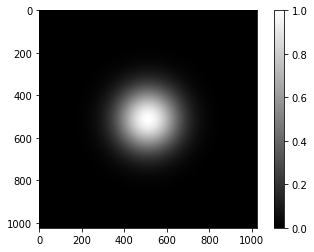

In [21]:
def HorizontalSine(shape, wavelength):
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  return np.sin(2 * np.pi * X / wavelength)

def VerticalSine(shape, wavelength):
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  return np.sin(2 * np.pi * Y / wavelength)

def DiagonalSine(shape, wavelength, angle = np.pi / 4):
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  return np.sin( 2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)

def Gauss(shape, A=1):
  x_mean = int(shape[0]/2)
  y_mean = int(shape[1]/2)
  x_sigma = int(shape[0]/10)
  y_sigma = int(shape[1]/10)
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  return A*np.exp(-((X-x_mean)**2/(2*x_sigma**2)+(Y-y_mean)**2/(2*y_sigma**2)))

def Circle(shape, r=10): #Lowpass
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  x_center = int(shape[0]/2)
  y_center = int(shape[1]/2)
  image = np.sqrt((X-x_center)**2 + (Y-y_center)**2)
  return image <= r # all values smaller or equal as r are set true

def NegativeCircle(shape, r=10): #Highpass
  X, Y = np.meshgrid(np.arange(0, shape[0], 1), np.arange(0, shape[1], 1))
  x_center = int(shape[0]/2)
  y_center = int(shape[1]/2)
  image = np.sqrt((X-x_center)**2 + (Y-y_center)**2)
  return image > r # all values bigger as r are set true

def Rect(shape, height = 30, width = 10):
  image = np.zeros(shape)
  x_min = int(shape[0]/2 - width/2)
  x_max = int(shape[0]/2 + width/2)
  y_min = int(shape[1]/2 - height/2)
  y_max = int(shape[1]/2 + height/2)
  image[y_min:y_max,x_min:x_max]=1
  return image

def VerticalRect(shape):
  return Rect(shape, shape[0]/4,shape[1]/8)

def HorizontalRect(shape):
  return Rect(shape, shape[0]/8,shape[1]/4)

plt.imshow(Gauss((1024,1024)), cmap='gray')
plt.colorbar()

In [15]:
def PlotFFT(image, plot3D = True, realFFT = False, plotPhase = True, xlim = None, ylim=None):

  # Spectrum calculation
  if realFFT:
    # FFT Shift only over height axis if real FFT
    spectrum = np.fft.fftshift(np.fft.rfft2(image,axes=(- 2, - 1)),axes = [-2])
    inverse_DFT = np.fft.irfft2(np.fft.ifftshift(spectrum,axes = [-2]))
    # axis labels for spectrum to allign with shifted signal
    extent = [
      0,np.shape(spectrum)[-1],
      -int(np.shape(spectrum)[-2]/2),int(np.shape(spectrum)[-2]/2)]
  else:
    spectrum = np.fft.fftshift(np.fft.fft2(image,axes=(- 2, - 1)))
    #spectrum = tf.signal.fftshift(tf.signal.fft2d(image))
    inverse_DFT = np.fft.ifft2(np.fft.ifftshift(spectrum)).real
    extent = [
      -int(np.shape(spectrum)[-1]/2),int(np.shape(spectrum)[-1]/2),
      -int(np.shape(spectrum)[-2]/2),int(np.shape(spectrum)[-2]/2)]
    
  amplitude_spectrum = np.log( #scaling in amplitude
        np.abs(spectrum)**2 # amplitudes of complex spectrum
    )
  if plotPhase:
    phase_spectrum = np.angle(spectrum)
    columns = 4
  else:
    columns = 3

  #3D Plot preparation
  if plot3D:
      rows = 2
  else:
      rows = 1

  # Plotting
  fig = plt.figure(figsize=[columns*8,6*rows])
  fig.suptitle("2D DFT & iDFT", fontsize=20)

  ax = fig.add_subplot(rows, columns, 1)
  ax.set_title('Image')
  plt.imshow(image, cmap='gray')
  plt.colorbar()

  ax = fig.add_subplot(rows, columns, 2)
  ax.set_title('2D DFT Amplitude')
  plt.imshow(amplitude_spectrum, cmap='jet',extent=extent)
  if xlim:
    plt.xlim(xlim)
  if ylim:
    plt.ylim(ylim)
  plt.colorbar()

  if plotPhase:  
    ax = fig.add_subplot(rows, columns, 3)
    ax.set_title('2D DFT Phase')
    plt.imshow(phase_spectrum, cmap='jet',extent=extent)
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)
    plt.colorbar()

  ax = fig.add_subplot(rows, columns, columns)
  ax.set_title('2D iDFT')
  plt.imshow(inverse_DFT, cmap='gray')
  plt.colorbar()
    
  if plot3D:
      #print(np.shape(spectrum))
      X, Y = np.meshgrid(range(0,np.shape(image)[0]), range(0,np.shape(image)[1]))
      if realFFT:
        X_freq, Y_freq = np.meshgrid(range(0,np.shape(spectrum)[-2]), range(-int(np.shape(spectrum)[-1]/2),int(np.shape(spectrum)[-1]/2)))
      else:
        X_freq, Y_freq = np.meshgrid(range(-int(np.shape(spectrum)[-2]/2),int(np.shape(spectrum)[-2]/2)), range(-int(np.shape(spectrum)[-1]/2),int(np.shape(spectrum)[-1]/2)))

      ax = fig.add_subplot(2, columns, columns+1,projection='3d')
      ax.set_title('Image')
      ax.plot_surface(X,Y,image,cmap='gray')

      ax = fig.add_subplot(2, columns, columns+2,projection='3d')
      ax.set_title('2D DFT Amplitude')
      ax.plot_surface(X_freq,Y_freq,amplitude_spectrum,cmap='jet')

      if plotPhase:
        ax = fig.add_subplot(2, columns, columns+3,projection='3d')
        ax.set_title('2D DFT Phase')
        ax.plot_surface(X_freq,Y_freq,phase_spectrum,cmap='jet')

      ax = fig.add_subplot(2, columns, 2*columns,projection='3d')
      ax.set_title('2D iDFT')
      ax.plot_surface(X,Y,inverse_DFT,cmap='gray')

  plt.show()

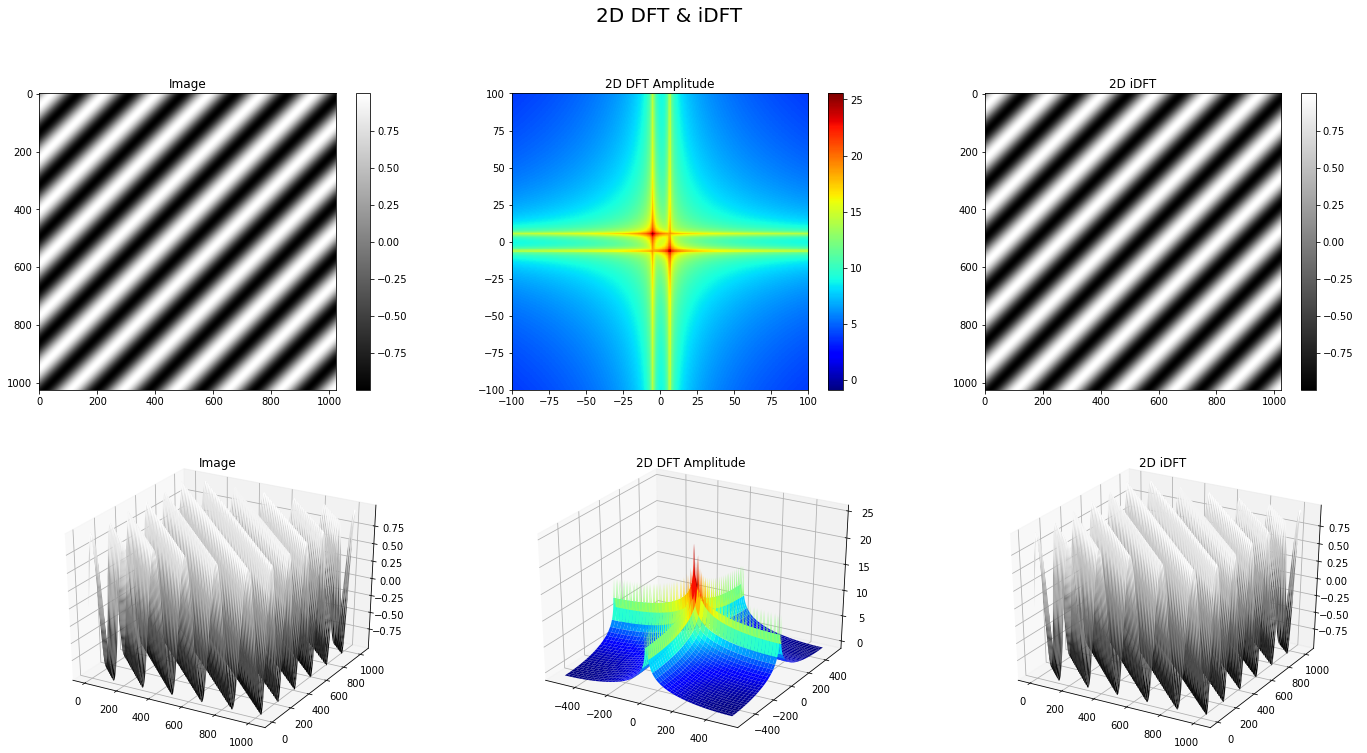

In [22]:
PlotFFT(DiagonalSine(shape=(1024,1024), wavelength=128),plot3D = True,realFFT = False, plotPhase = False, xlim=[-100,100], ylim=[-100,100])

In [8]:
!wget https://raw.githubusercontent.com/sascha-kirch/sascha-kirch.github.io/main/docs/assets/images/emojos.png

--2022-05-19 20:39:51--  https://raw.githubusercontent.com/sascha-kirch/sascha-kirch.github.io/main/docs/assets/images/emojos.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 515518 (503K) [image/png]
Saving to: ‘emojos.png’

emojos.png          100%[===================>] 503.44K  --.-KB/s    in 0.02s   

2022-05-19 20:39:51 (21.8 MB/s) - ‘emojos.png’ saved [515518/515518]



In [9]:
imageFilePath = "/content/emojos.png"
image = cv2.imread(imageFilePath,0) # read Gray Scale
H,W = np.shape(image)
side_length = min(H,W)
image = image[0:side_length,0:side_length] # crop and only use single color channel

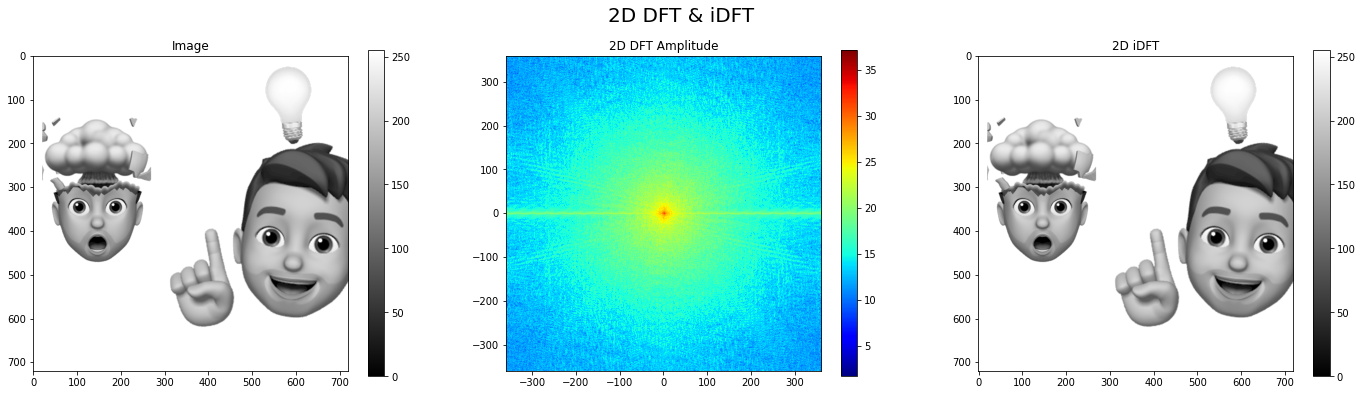

In [23]:
PlotFFT(image,plot3D = False,realFFT = False, xlim=None, ylim=None, plotPhase = False)

In [35]:
def PlotFFTWithFilter(image, filter, xlim = None, ylim=None, cropToMask = False, shiftFFT = True, plotPhase = True):

  # Spectrum calculation
  if shiftFFT:
    spectrum = np.fft.fftshift(np.fft.fft2(image,axes=(- 2, - 1)))
    inverse_DFT = np.fft.ifft2(np.fft.ifftshift(spectrum)).real
  else:
    spectrum = np.fft.fft2(image,axes=(- 2, - 1))
    inverse_DFT = np.fft.ifft2(spectrum).real
  amplitude_spectrum = np.log( #scaling in amplitude
        np.abs(spectrum)**2 # amplitudes of complex spectrum
    )
  if plotPhase:
    phase_spectrum = np.angle(spectrum)
    columns = 4
  else:
    columns = 3
  extent = [
      -int(np.shape(spectrum)[-1]/2),int(np.shape(spectrum)[-1]/2),
      -int(np.shape(spectrum)[-2]/2),int(np.shape(spectrum)[-2]/2)]

  if cropToMask:
    temp = spectrum * filter
    true_points = np.argwhere(filter)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    filtered_spectrum = temp[top_left[0]:bottom_right[0]+1,top_left[1]:bottom_right[1]+1]    
  else:
    filtered_spectrum = spectrum * filter
  filtered_extent = [
      -int(np.shape(filtered_spectrum)[-1]/2),int(np.shape(filtered_spectrum)[-1]/2),
      -int(np.shape(filtered_spectrum)[-2]/2),int(np.shape(filtered_spectrum)[-2]/2)]
  filtered_amplitude_spectrum = np.log(np.abs(filtered_spectrum)**2)
  if plotPhase:
    filtered_phase_spectrum = np.angle(filtered_spectrum)
  if shiftFFT:
    filtered_inverse_DFT = np.fft.ifft2(np.fft.ifftshift(filtered_spectrum)).real
  else:
    filtered_inverse_DFT = np.fft.ifft2(filtered_spectrum).real

  # Plotting
  fig = plt.figure(figsize=[columns*8,12])
  fig.suptitle("2D DFT & iDFT", fontsize=20)

  ax = fig.add_subplot(2, columns, 1)
  ax.set_title('Image')
  plt.imshow(image, cmap='gray')
  plt.colorbar()

  ax = fig.add_subplot(2, columns, 2)
  ax.set_title('2D DFT Amplitude')
  plt.imshow(amplitude_spectrum, cmap='jet',extent=extent)
  if xlim:
    plt.xlim(xlim)
  if ylim:
    plt.ylim(ylim)
  plt.colorbar()

  if plotPhase:
    ax = fig.add_subplot(2, columns, 3)
    ax.set_title('2D DFT Phase')
    plt.imshow(phase_spectrum, cmap='jet',extent=extent)
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)
    plt.colorbar()

  ax = fig.add_subplot(2, columns, columns)
  ax.set_title('2D iDFT')
  plt.imshow(inverse_DFT, cmap='gray', vmin=0, vmax=255)
  plt.colorbar()

  ax = fig.add_subplot(2, columns, columns+1)
  ax.set_title('Filter F-Domain')
  plt.imshow(filter, cmap='gray')
  plt.colorbar()

  ax = fig.add_subplot(2, columns, columns+2)
  ax.set_title('Filtered Amplitude Spectrum')
  plt.imshow(filtered_amplitude_spectrum, cmap='jet',extent=filtered_extent)
  if xlim:
    plt.xlim(xlim)
  if ylim:
    plt.ylim(ylim)
  plt.colorbar()

  if plotPhase:
    ax = fig.add_subplot(2, columns, columns+3)
    ax.set_title('Filtered Phase Spectrum')
    plt.imshow(filtered_phase_spectrum, cmap='jet',extent=filtered_extent)
    if xlim:
      plt.xlim(xlim)
    if ylim:
      plt.ylim(ylim)
    plt.colorbar()

  ax = fig.add_subplot(2, columns, 2*columns)
  ax.set_title('Filtered iDFT')
  plt.imshow(filtered_inverse_DFT, cmap='gray', vmin=0, vmax=255)
  plt.colorbar()

  plt.show()

# Gauss Filter (smoothing)

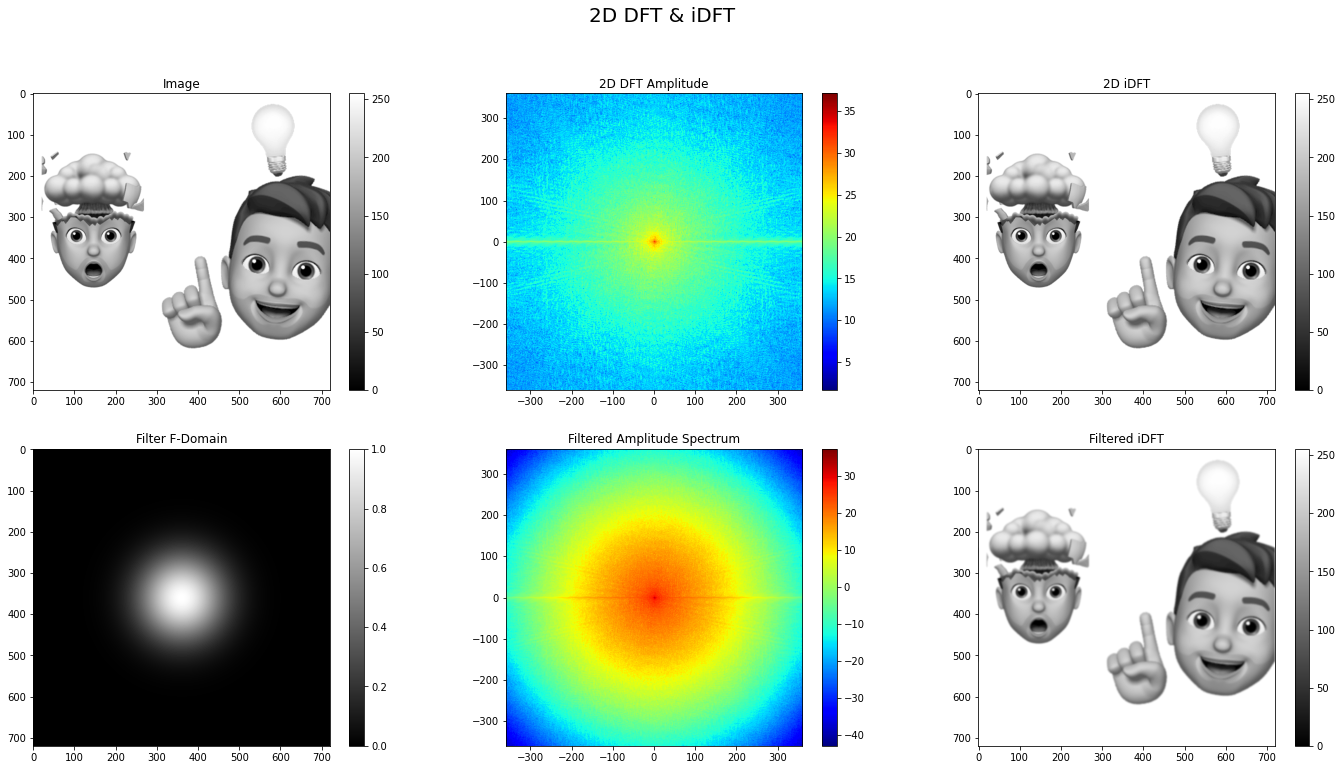

In [34]:
filter = Gauss(np.shape(image))
PlotFFTWithFilter(image, filter, cropToMask = False, shiftFFT = True, plotPhase = False)

# Low Pass Filtering

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


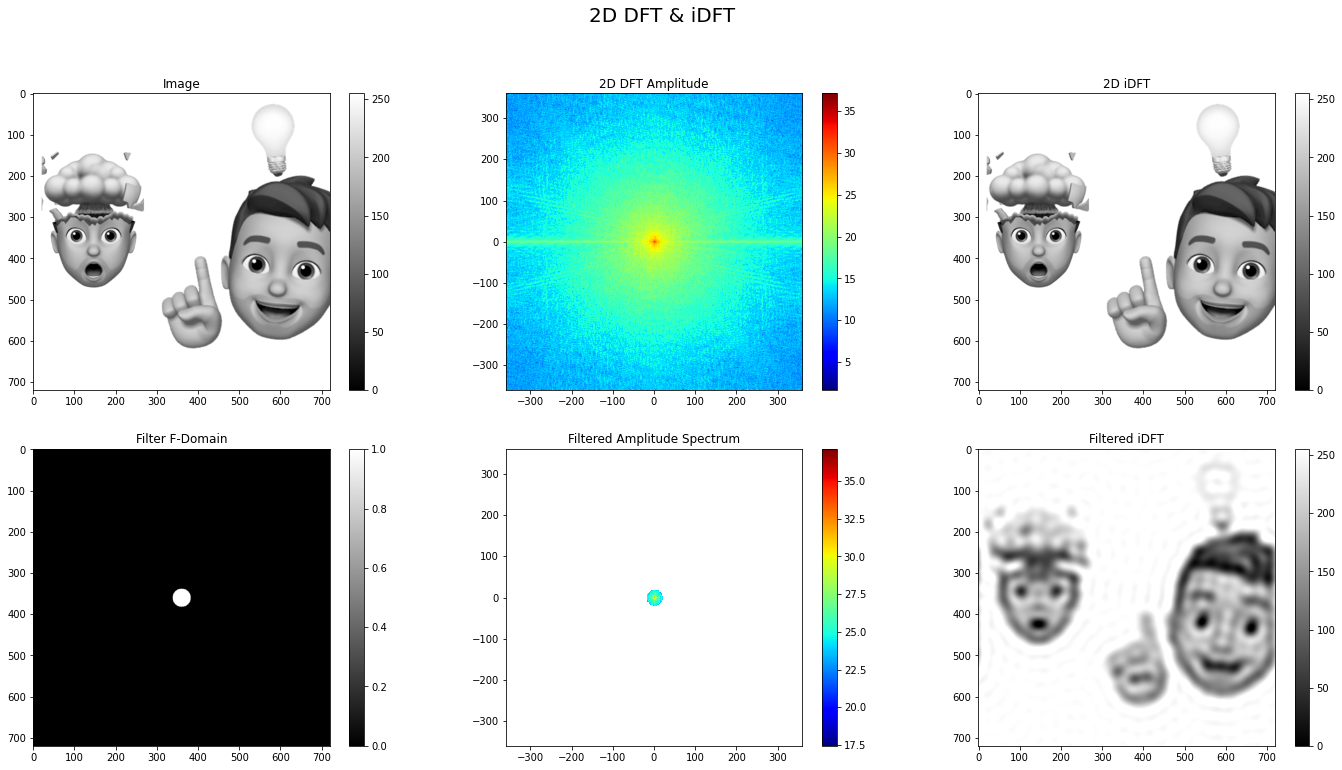

In [30]:
filter = Circle(np.shape(image),r= int(side_length/32))
PlotFFTWithFilter(image, filter, cropToMask = False, shiftFFT = True, plotPhase = False)

# High Pass Filtering

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


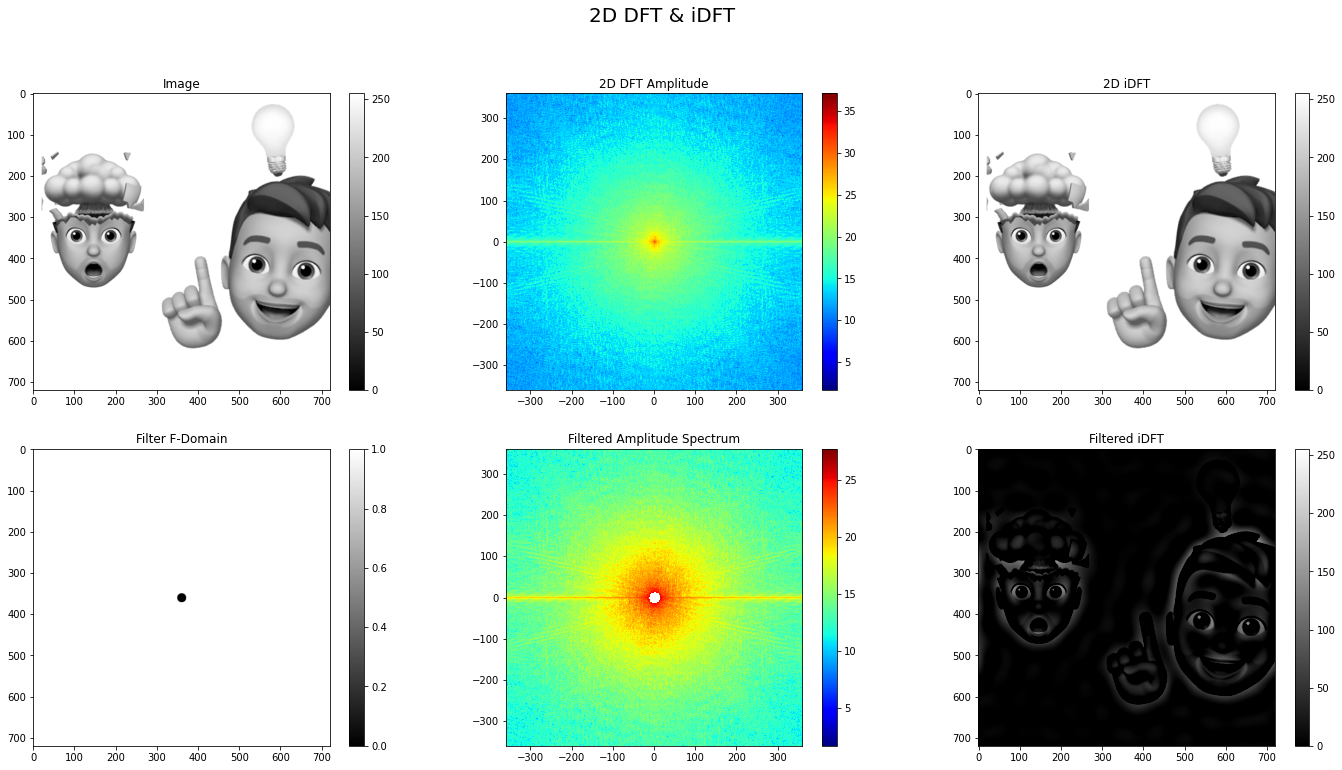

In [33]:
filter = NegativeCircle(np.shape(image),r= int(side_length/64))
PlotFFTWithFilter(image, filter, cropToMask = False, shiftFFT = True, plotPhase = False)

# Rect Filter

Observation:
- trancating high frequency components has small impact on image quality after inverse transformation
- trancated parts of the spectrum must be considered in iDFT. This means that the sequence length N and M must be used for iDFT
- Can be used as pooling layer, if not directly transformed back. Could be used for classification in frequency domain or requires up sampling at a certain point

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


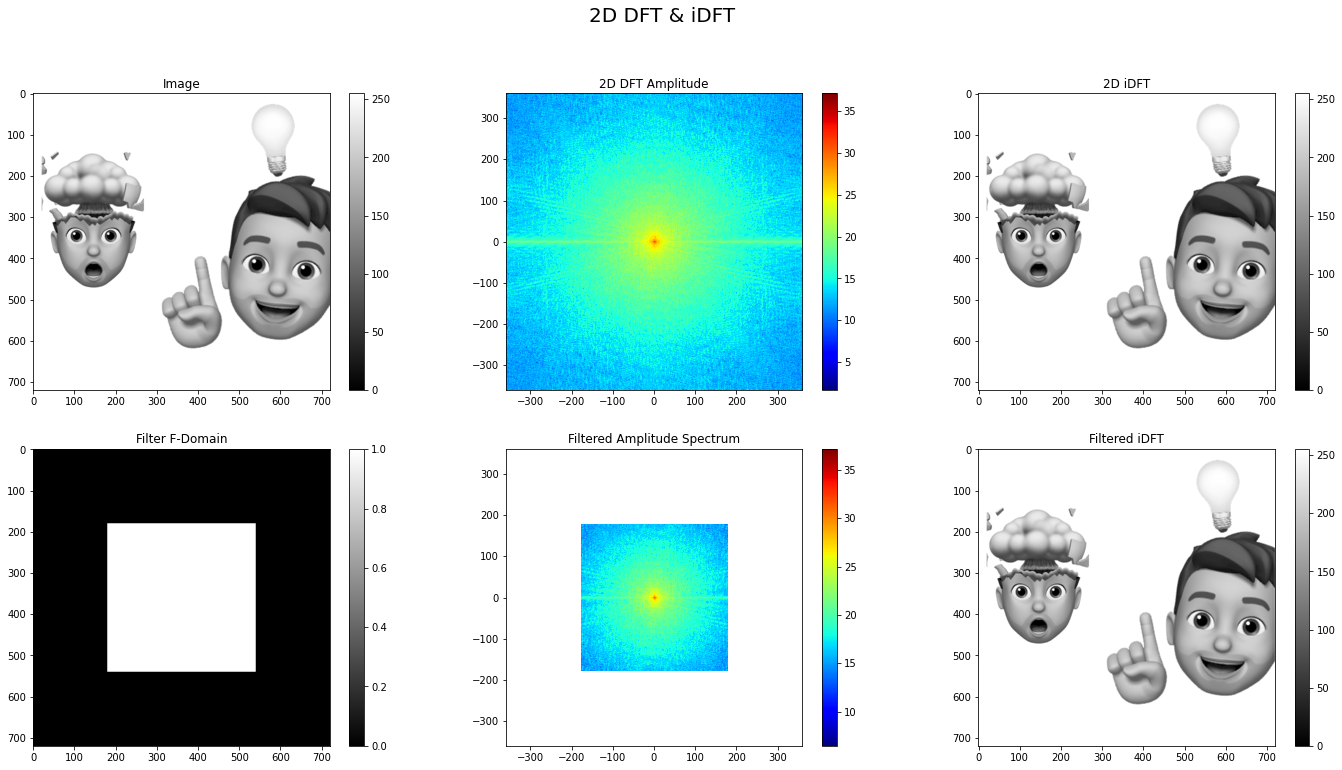

In [32]:
filter = Rect(np.shape(image),height= int(side_length/2),width=int(side_length/2))
PlotFFTWithFilter(image, filter, cropToMask = False, shiftFFT = True, plotPhase = False)